# Machine Learning

In this homework we will gain experience on Applied Machine Learning, exploring an interesting dataset about soccer players and referees. 

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt  
% matplotlib inline
import random
from datetime import datetime
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
import sklearn as sk
from sklearn import preprocessing, ensemble
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

/Users/peco/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load data from pre-processing

In [2]:
df_p = pd.read_csv("crowdstorm_players_aggregated.csv", encoding = "utf-8")

# Machine Learning

## Preparation of the data
First let's create a vector *X* of features and samples, and a vector *Y* of the labels corresponding. Y will have the value of *mean_rater*

In [3]:
df_y = df_p['mean_rater']

df_x = df_p.copy()
df_x.drop(['mean_rater'],inplace=True,axis=1,errors='ignore')

df_x.describe()

,meanExp,defeats,meanIAT,victories,redReferee,weight,yellowReferee,seIAT,height,seExp,...,Center Forward,Center Midfielder,Defensive Midfielder,Goalkeeper,Left Fullback,Left Midfielder,Left Winger,Right Fullback,Right Midfielder,Right Winger
count,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,...,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000
mean,0.444205,561.917489,0.347126,820.600141,0.009861,76.263047,0.325326,0.000293,182.159379,0.001399,...,0.133286,0.041608,0.120592,0.111425,0.082511,0.053597,0.037377,0.075458,0.042313,0.039492
std,0.101160,573.695929,0.014516,1019.439932,0.015333,7.105262,0.265622,0.000390,6.799995,0.001957,...,0.340004,0.199762,0.325768,0.314768,0.275238,0.225299,0.189750,0.264223,0.201374,0.194832
min,0.065271,0.000000,0.287530,0.000000,0.000000,55.000000,0.000000,0.000010,161.000000,0.000037,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.361671,173.000000,0.336628,197.000000,0.000000,71.000000,0.140651,0.000120,178.000000,0.000547,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.402253,384.500000,0.340851,497.000000,0.002115,76.000000,0.256060,0.000229,182.500000,0.001002,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.551277,749.750000,0.361154,1068.750000,0.014864,81.000000,0.447792,0.000306,187.000000,0.001437,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.031407,4269.000000,0.396512,10092.000000,0.105786,100.000000,2.002729,0.009063,203.000000,0.045650,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Imabalanced Classes
We have more data in the class '0' (White skin), than in the class '1' (Dark skin). We compute their ratio, and will use it in the classifer.

In [4]:
df_y = df_y.astype(int)
a,b = df_y.value_counts()
weight_1 = a/(a+b)
weight_0 = b/(a+b)
print('Number of samples in each class:')
df_y.value_counts()

Number of samples in each class:


0    1088
1     330
Name: mean_rater, dtype: int64

### Division of the dataset in train/test datasets
we will use a training set containing 80% of the data, and a testing set containing 20% of the data

when specifying *random_state = 0*, we make sure that the splitting is done everytime at the same place. We can remove this option to have a random splitting.

In [5]:
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=.2, random_state = 0)
#df_y_test = np.asarray(df_y_test, dtype="|S6")
#df_x_test = np.asarray(df_x_test, dtype="|S6")
#df_y_train = np.asarray(df_y_train, dtype="|S6")
#df_x_train = np.asarray(df_x_train, dtype="|S6")

df_x_train.shape, df_y_train.shape, df_x_test.shape, df_y_test.shape

((1134, 31), (1134,), (284, 31), (284,))

## Random Forest

As the data are unbalanced, the model will be **penalized** using the weights calculated before. This will allow the model to take into considerationt the fact that there are more white skin players than dark skin players.

### Metric choice

We are going to use two metrics :

The **precision** :
$P = TP / (TP+FP) $

The **acuracy** :
$P = (TP+TN) / N $

The precision will give information about how black players are classified (given by **TP**). The accuracy will give information about how black and white players are classified.


### First try with naive parameters

In [6]:
# TRAIN RANDOM FOREST

# Train model
rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=100,class_weight={1:weight_1,0:weight_0})
rand_forest_model.fit(df_x_train,df_y_train)

# Predict
y_pred = rand_forest_model.predict(df_x_test)
y_pred_train = rand_forest_model.predict(df_x_train)

# Compute accuracy on training set
accuracy_rand_forest_training = sk.metrics.accuracy_score(df_y_train,y_pred_train)
print("Training accuracy score on training set")
print(accuracy_rand_forest_training)
print("Training precision score")
print(sk.metrics.precision_score(df_y_train,y_pred_train))

# Compute accuracy on test set
accuracy_rand_forest = sk.metrics.accuracy_score(df_y_test,y_pred)
print("Test accuracy score")
print(accuracy_rand_forest)
print("Test precision score")
print(sk.metrics.precision_score(df_y_test,y_pred))

# Confusion matrix
print("Confusion matrix")
cfm = sk.metrics.confusion_matrix(df_y_test,y_pred)
print(cfm)

Training accuracy score on training set
1.0
Training precision score
1.0
Test accuracy score
0.799295774648
Test precision score
0.52
Confusion matrix
[[214  12]
 [ 45  13]]


The model is **overfitting**. This is probably due to the depth of the trees being too high. We will train the model again with a smaller *max_depth* of 10. We show here that this value reduces overfitting. Later, we will do a cross validation to identify the best value for the *max_depth* hyperparameter.


In [7]:
# Train model
rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=100, max_depth=10,class_weight={1:weight_1,0:weight_0})
rand_forest_model.fit(df_x_train,df_y_train)

# Predict
y_pred = rand_forest_model.predict(df_x_test)
y_pred_train = rand_forest_model.predict(df_x_train)

# Compute accuracy on training set
accuracy_rand_forest_training = sk.metrics.accuracy_score(df_y_train,y_pred_train)
print("Training accuracy score on training set")
print(accuracy_rand_forest_training)
print("Training precision score")
print(sk.metrics.precision_score(df_y_train,y_pred_train))

# Compute accuracy on test set
accuracy_rand_forest = sk.metrics.accuracy_score(df_y_test,y_pred)
print("Test accuracy score")
print(accuracy_rand_forest)
print("Test precision score")
print(sk.metrics.precision_score(df_y_test,y_pred))

# Confusion matrix
print("Confusion matrix")
cfm = sk.metrics.confusion_matrix(df_y_test,y_pred)
print(cfm)

Training accuracy score on training set
0.977072310406
Training precision score
0.939285714286
Test accuracy score
0.795774647887
Test precision score
0.5
Confusion matrix
[[197  29]
 [ 29  29]]


The accuracy score on the training test is now smaller, the overfitting issue has been reduced. however, we can see that both the test accuracy and precision have been reduced.

## Cross validation

we will define K = 10 folds. We will do a cross validation for the hyperparameter *number of trees* and another one for *max_depth*. In both case we will use the accuracy as the score.


In [8]:
num_folds = 10

### 1 hyperparameter : number of trees

Choices for the number of estimators hyperparameter:

In [9]:
number_trees = [1, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [10]:
rf_scores = []
rf_param = []

#Loop for 1st hyperparameter n_estimators
for number_trees_idx, number_trees_value in enumerate(number_trees):
    
    print('number_trees_idx: ',number_trees_idx+1,'/',len(number_trees),', value: ', number_trees_value)

    # Random forest
    rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=number_trees_value, max_depth=14,class_weight={1:weight_1,0:weight_0})

    #Scores
    scores = cross_val_score(rand_forest_model, df_x_train, df_y_train, cv=num_folds, scoring='accuracy')
    rf_scores.append(scores.mean())
    rf_param.append(number_trees_value)
    print('Accuracy = ', scores.mean())


number_trees_idx:  1 / 17 , value:  1
Accuracy =  0.705394382455
number_trees_idx:  2 / 17 , value:  5
Accuracy =  0.744301654482
number_trees_idx:  3 / 17 , value:  10
Accuracy =  0.775198153136
number_trees_idx:  4 / 17 , value:  20
Accuracy =  0.772558676414
number_trees_idx:  5 / 17 , value:  30
Accuracy =  0.777822239323
number_trees_idx:  6 / 17 , value:  40
Accuracy =  0.783970757984
number_trees_idx:  7 / 17 , value:  50
Accuracy =  0.777929973067
number_trees_idx:  8 / 17 , value:  100
Accuracy =  0.77872258561
number_trees_idx:  9 / 17 , value:  200
Accuracy =  0.783178145441
number_trees_idx:  10 / 17 , value:  300
Accuracy =  0.776937283571
number_trees_idx:  11 / 17 , value:  400
Accuracy =  0.783162754906
number_trees_idx:  12 / 17 , value:  500
Accuracy =  0.786733358984
number_trees_idx:  13 / 17 , value:  600
Accuracy =  0.777853020392
number_trees_idx:  14 / 17 , value:  700
Accuracy =  0.781377452866
number_trees_idx:  15 / 17 , value:  800
Accuracy =  0.779638322432

We will now plot the cross-validated accuracy for different number of trees and display the value of the best model

best accuracy:
0.786733358984
best parameter:
500


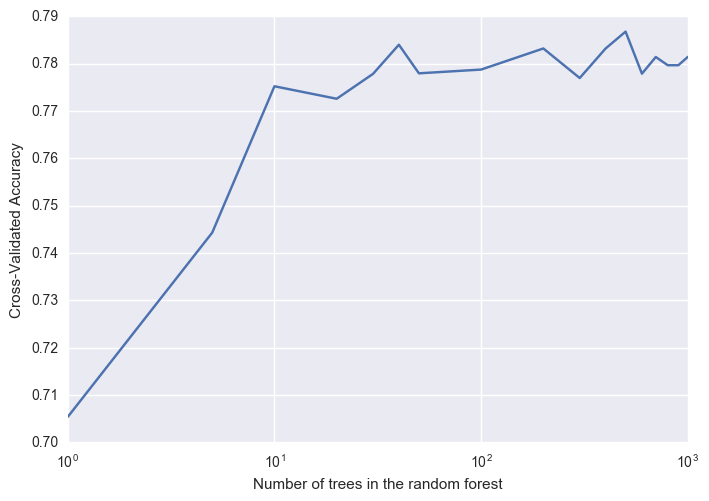

In [11]:
plt.semilogx(rf_param,rf_scores)
plt.xlabel('Number of trees in the random forest')
plt.ylabel('Cross-Validated Accuracy')

idx_best = np.argmax(rf_scores)
idx_worst = np.argmin(rf_scores)

print('best accuracy:')
print(np.max(rf_scores))
print('best parameter:')
best_param = rf_param[idx_best]
worst_param = rf_param[idx_worst]
print(best_param)

### Second hyperparameter : max_depth

Choices for the number of estimators hyperparameter:

In [12]:
max_depth_choices = [1, 2, 3, 4,5, 6, 7, 8, 10, 12, 14, 16, 18, 20,30, 40, 60, 80, 100 ]

In [13]:
rf_scores = []
rf_param = []

#Loop for 1st hyperparameter n_estimators
for max_depth_choices_idx, max_depth_choices_value in enumerate(max_depth_choices):
    
    print('max_depth_choices_idx: ',max_depth_choices_idx+1,'/',len(max_depth_choices),', value: ',max_depth_choices_value)

    # Random forest
    rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=best_param, max_depth=max_depth_choices_value,class_weight={1:weight_1,0:weight_0})

    #Scores
    scores = cross_val_score(rand_forest_model, df_x_train, df_y_train, cv=num_folds, scoring='accuracy')
    rf_scores.append(scores.mean())
    rf_param.append(max_depth_choices_value)
    print('Accuracy = ', scores.mean())


max_depth_choices_idx:  1 / 19 , value:  1
Accuracy =  0.707302808773
max_depth_choices_idx:  2 / 19 , value:  2
Accuracy =  0.716060023086
max_depth_choices_idx:  3 / 19 , value:  3
Accuracy =  0.716960369373
max_depth_choices_idx:  4 / 19 , value:  4
Accuracy =  0.730142362447
max_depth_choices_idx:  5 / 19 , value:  5
Accuracy =  0.743401308195
max_depth_choices_idx:  6 / 19 , value:  6
Accuracy =  0.750496344748
max_depth_choices_idx:  7 / 19 , value:  7
Accuracy =  0.753151212005
max_depth_choices_idx:  8 / 19 , value:  8
Accuracy =  0.763755290496
max_depth_choices_idx:  9 / 19 , value:  10
Accuracy =  0.784016929588
max_depth_choices_idx:  10 / 19 , value:  12
Accuracy =  0.780538668719
max_depth_choices_idx:  11 / 19 , value:  14
Accuracy =  0.774343978453
max_depth_choices_idx:  12 / 19 , value:  16
Accuracy =  0.782247018084
max_depth_choices_idx:  13 / 19 , value:  18
Accuracy =  0.781377452866
max_depth_choices_idx:  14 / 19 , value:  20
Accuracy =  0.786641015775
max_depth

best accuracy:
0.788426317815
best parameter:
40


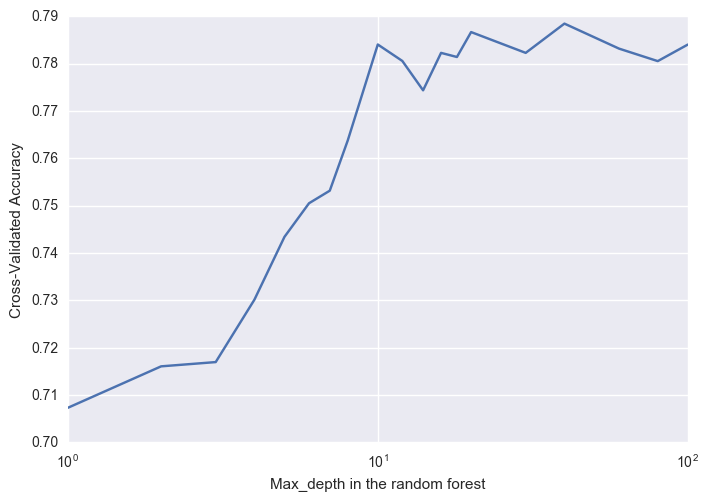

In [14]:
plt.semilogx(rf_param,rf_scores)
plt.xlabel('Max_depth in the random forest')
plt.ylabel('Cross-Validated Accuracy')

idx_best = np.argmax(rf_scores)
idx_worst = np.argmin(rf_scores)

print('best accuracy:')
print(np.max(rf_scores))
print('best parameter:')
best_param_depth = rf_param[idx_best]
worst_param_depth = rf_param[idx_worst]
print(best_param_depth)

## Best model
What are the scores given the best hyperparameters obtained in the cross validation before.

In [15]:
# Train model
rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=best_param, max_depth=best_param_depth,class_weight={1:weight_1,0:weight_0})
rand_forest_model.fit(df_x_train,df_y_train)

# Predict
y_pred = rand_forest_model.predict(df_x_test)
y_pred_train = rand_forest_model.predict(df_x_train)

# Compute accuracy on training set
accuracy_rand_forest_training = sk.metrics.accuracy_score(df_y_train,y_pred_train)
print("Training accuracy score on training set")
print(accuracy_rand_forest_training)
print("Training precision score")
print(sk.metrics.precision_score(df_y_train,y_pred_train))

# Compute accuracy on test set
accuracy_rand_forest = sk.metrics.accuracy_score(df_y_test,y_pred)
print("Test accuracy score")
print(accuracy_rand_forest)
print("Test precision score")
print(sk.metrics.precision_score(df_y_test,y_pred))

# Confusion matrix
print("Confusion matrix")
cfm = sk.metrics.confusion_matrix(df_y_test,y_pred)
print(cfm)

Training accuracy score on training set
1.0
Training precision score
1.0
Test accuracy score
0.806338028169
Test precision score
0.555555555556
Confusion matrix
[[214  12]
 [ 43  15]]


## Feature importances

In [35]:
# Random forest
rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=best_param,max_depth=best_param_depth,class_weight={1:weight_1,0:weight_0})
#df_y = np.asarray(df_y, dtype="|S6")
rand_forest_model.fit(df_x,df_y)

RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.23272214386459802, 1: 0.767277856135402},
            criterion='gini', max_depth=40, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
importances = rand_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

Feature ranking:
1. feature meanExp (0.096703), indice 2
2. feature defeats (0.092782), indice 7
3. feature meanIAT (0.087864), indice 0
4. feature victories (0.084398), indice 9
5. feature redReferee (0.066805), indice 6
6. feature weight (0.062862), indice 11
7. feature yellowReferee (0.059800), indice 1
8. feature seIAT (0.056241), indice 12
9. feature height (0.055476), indice 3
10. feature seExp (0.053944), indice 10
11. feature ties (0.047041), indice 8
12. feature goals (0.046378), indice 5
13. feature games (0.045266), indice 14
14. feature allCards (0.036957), indice 4
15. feature age (0.026803), indice 13
16. feature England (0.021861), indice 16
17. feature France (0.019910), indice 17
18. feature Germany (0.011751), indice 19
19. feature Spain (0.009896), indice 18
20. feature Attacking Midfielder (0.009578), indice 15
21. feature Center Back (0.007684), indice 20


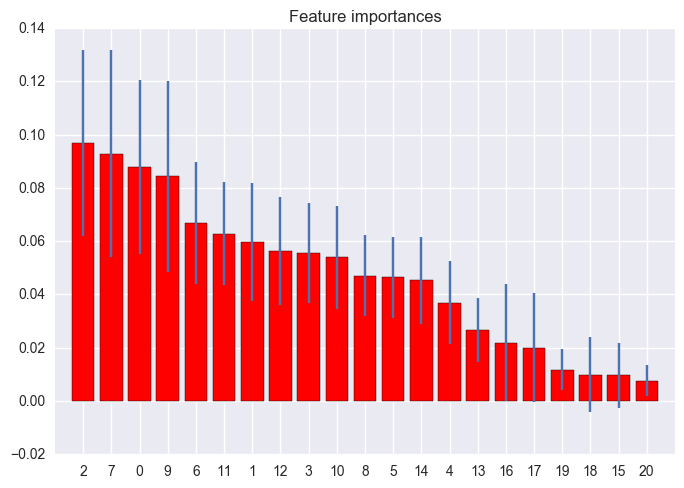

In [37]:
# Get the importance of the features
importances = rand_forest_model.feature_importances_

# Compute the standard deviation
std = np.std([tree.feature_importances_ for tree in rand_forest_model.estimators_], axis=0)

# Get the indices of the most important features, in descending order
indices = np.argsort(importances)[::-1]

variable_importance = []

# Print the feature ranking
print("Feature ranking:")


for feature in range(df_x.shape[1]):
    print("%d. feature %s (%f), indice %d" % (feature+1, df_x.columns[feature], importances[indices[feature]], indices[feature]))
    variable_importance.append({'Variable': df_x.columns[feature], 'Importance': importances[indices[feature]]})

variable_importance=pd.DataFrame(variable_importance)
plt.figure()

plt.title("Feature importances")
plt.bar(range(df_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_x.shape[1]), indices)
plt.xlim([-1, df_x.shape[1]])
plt.show()

Let's now remove the features that we assume are the least useful to determine one's skin color.

We will delete the 10 most insignificant features, and retrain the model.

In [38]:
s=len(variable_importance)
col_to_remove=variable_importance[s-10:s]['Variable']
df_x.drop(col_to_remove,inplace=True,axis=1,errors='ignore')

In [39]:
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=.2, random_state = 0)

rand_forest_model.fit(df_x_train,df_y_train)
y_pred = rand_forest_model.predict(df_x_test)

# Compute accuracy 
accuracy_rand_forest = sk.metrics.accuracy_score(df_y_test,y_pred)
print("Test accuracy score")
print(accuracy_rand_forest)
print("Test precision score")
print(sk.metrics.precision_score(df_y_test,y_pred))


Test accuracy score
0.795774647887
Test precision score
0.5


Let's have a look at the features importance now

Feature ranking:
1. feature meanExp (0.126258), indice 2
2. feature defeats (0.125707), indice 7
3. feature meanIAT (0.122965), indice 0
4. feature victories (0.113786), indice 9
5. feature redReferee (0.091350), indice 6
6. feature weight (0.089274), indice 1
7. feature yellowReferee (0.080807), indice 10
8. feature seIAT (0.076558), indice 3
9. feature height (0.063156), indice 8
10. feature seExp (0.060175), indice 5
11. feature ties (0.049962), indice 4


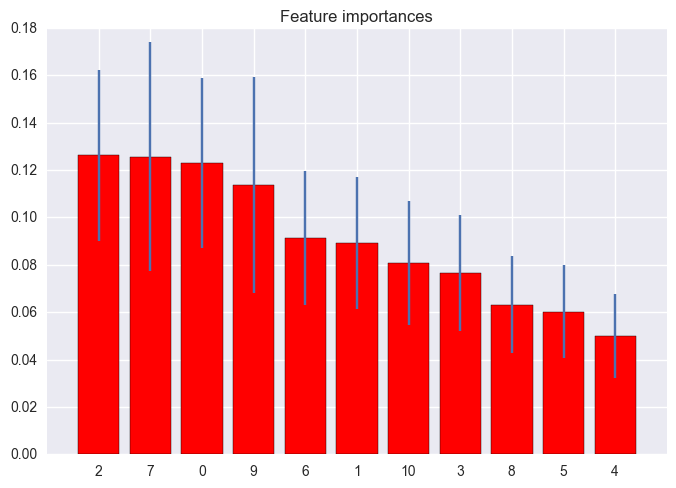

In [40]:
importances = rand_forest_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rand_forest_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_x.shape[1]):
    print("%d. feature %s (%f), indice %d" % (f + 1, df_x.columns[f], importances[indices[f]], indices[f]))
plt.figure()

plt.title("Feature importances")
plt.bar(range(df_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_x.shape[1]), indices)
plt.xlim([-1, df_x.shape[1]])
plt.show()

### Observations.

It is hard to see which features are really more important than the others. An interesting point is the fact that *victories* and *defeats* are both among the first 4 features, which seems to be a contradiction. 


## Bonus question

We decide to do 2 graphs of learning curves:
- The best model (best hyperparameters were found in cross-validation)
- The simplest model (with a number of tree of 1, max depth of 1)

### Learning curve of the best model

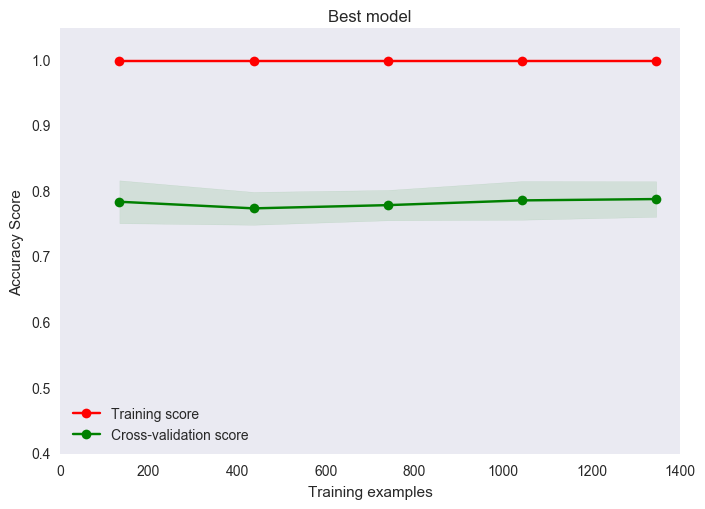

In [22]:
rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=best_param,max_depth=best_param_depth)


plt.figure()
plt.title("Best model")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
train_sizes, train_scores, test_scores = learning_curve(rand_forest_model, df_x, df_y, cv=20)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()


plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

axes = plt.gca()
axes.set_ylim([0.4,1.05])

plt.legend(loc="best")

As we can see the model has a pretty high accuracy but is overfitting.

### Learning curve of the simplest model
number of trees = 1, max_depth = 1.

The curve on the left shows the simplest model with weight taken into consideration.
The curve on the right shows the simplest model, without taking weights into consideration.


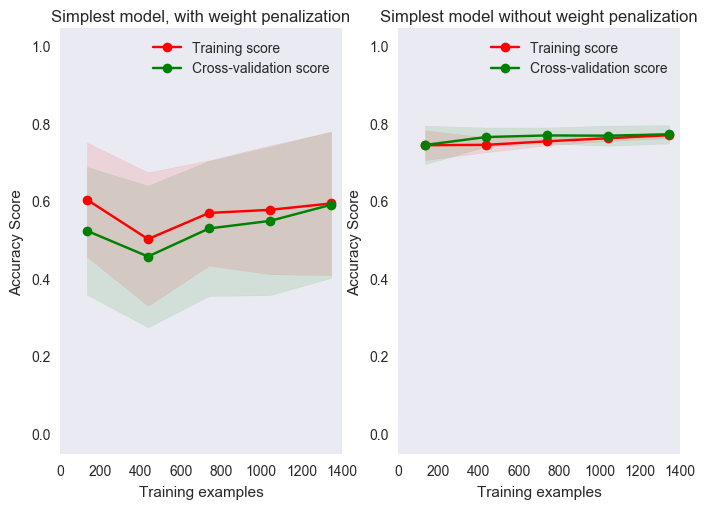

In [56]:
# With weights
plt.subplot(1, 2, 1)
rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=1,max_depth=1,class_weight={1:weight_1,0:weight_0})


plt.title("Simplest model, with weight penalization")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
train_sizes, train_scores, test_scores = learning_curve(
    rand_forest_model, df_x, df_y, cv=20)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
axes = plt.gca()
axes.set_ylim([-0.05,1.05])

plt.legend(loc="best")


# Without weights
plt.subplot(1, 2, 2)
rand_forest_model = sk.ensemble.RandomForestClassifier(n_estimators=1,max_depth=1)
plt.title("Simplest model without weight penalization")
plt.xlabel("Training examples")
plt.ylabel("Accuracy Score")
train_sizes, train_scores, test_scores = learning_curve(
    rand_forest_model, df_x, df_y, cv=20)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
axes = plt.gca()
axes.set_ylim([-0.05,1.05])

plt.legend(loc="best")

The curve on the left shows the simplest model with weight taken into consideration.
The curve on the right shows the simplest model, without taking weights into consideration.

The simplest model ever, with with weights init shows an accuracy of 50%. It means that it is not possible to classify a dark/white skin player. Also the standard deviaiton is really important, which shows how spread this data are.

The weights are important here. If we don't put them, we obtain an accuracy of 75%, which is actually the number of white skin player in our dataset!

## Discussion

#### Data Imbalance
The first thing to consider in this exercise was the class imbalance. Indeed, there are 76% of clear skin players. 
As the classes are unbalanced, there will be what is called the ["Accuracy Paradox"](https://en.wikipedia.org/wiki/Accuracy_paradox). In this case, we can do:
- use precision or recall rather than accuracy
- Penalize the model to take into consideration this imbalance.

We have decided to always use the accuracy, but we penalized the model, by giving weights in the initialization of the randomForest.

#### Features
We couldn't find the most meaningfull features.

#### Conclusion
We can draw several conclusions:
- It is impossible to classify correctly players based on their skin color 
- The random forest might not be the most suitable model here, maybe a neural network would be better.